# 1. Introducción y objetivo

Este laboratorio forma parte de la asignatura **Investigación de Operaciones Avanzadas**, a cargo del profesor **Marcelo Becerra**, y tiene como propósito aplicar metodologías de **optimización** y **aprendizaje automático** en un caso práctico de clasificación de imágenes médicas.

En este desafío enfrentaremos un **problema de clasificación binaria**, donde el objetivo es detectar la presencia de **Melanoma (1)** frente a **No Melanoma (0)** a partir de **fotografías clínicas de lesiones cutáneas**.  
El melanoma constituye uno de los tipos más agresivos de cáncer de piel, y su detección temprana es fundamental para mejorar el pronóstico y la supervivencia de los pacientes. Por ello, el desarrollo de modelos automáticos de apoyo diagnóstico tiene un impacto directo en la salud pública y en la toma de decisiones clínicas.

---

### Contexto

El cáncer de piel tipo melanoma representa una de las patologías más graves dentro de la dermatología.  
A pesar de su menor incidencia en comparación con otros tipos de cáncer cutáneo, presenta una alta tasa de mortalidad debido a su rápida capacidad de diseminación (metástasis).  
La identificación precoz de lesiones sospechosas mediante imágenes médicas es una herramienta clave para reducir riesgos, optimizar tratamientos y aumentar la tasa de supervivencia.

En este laboratorio, los estudiantes trabajarán con un **dataset de imágenes clínicas** organizadas en dos categorías:

- **Mel (Melanoma)**
- **NoMel (No Melanoma)**

El desafío consiste en entrenar un modelo de clasificación de imágenes capaz de distinguir entre ambas clases, analizando cómo distintos **hiperparámetros** —como la tasa de aprendizaje (*learning rate*), el número de épocas, el tamaño del *batch*, la regularización o la proporción de capas congeladas— afectan el desempeño del modelo.  
Estos hiperparámetros serán ajustados mediante algoritmos de optimización con el objetivo de maximizar el F1 Score en el conjunto de validación y, posteriormente, en el conjunto de prueba oculto.

---

### Objetivo general

Desarrollar un **modelo de clasificación binaria** de imágenes capaz de distinguir entre **Melanoma (1)** y **No Melanoma (0)**, empleando técnicas de **aprendizaje profundo (Deep Learning)** y **optimización de hiperparámetros** para lograr el mayor F1 Score posible.

---

### Objetivos específicos

1. Comprender el flujo completo de un sistema de clasificación de imágenes médicas: desde la exploración de los datos hasta la evaluación final.  
2. Implementar un modelo de red neuronal convolucional (CNN), aprovechando transfer learning con arquitecturas preentrenadas (por ejemplo, *MobileNetV3*).  
3. Aplicar técnicas de preprocesamiento y data augmentation para mejorar la capacidad de generalización del modelo.  
4. Optimizar los hiperparámetros clave mediante algoritmos de búsqueda (por ejemplo, *Optuna* con TPE o búsqueda bayesiana).  
5. Evaluar el rendimiento del modelo utilizando la métrica F1 Score, que combina *precision* y *recall*, siendo especialmente útil ante posibles desbalances de clases.  
6. Generar un archivo de **predicciones (`submission.csv`)** con las columnas:
   - `ID`: nombre del archivo de la imagen en el conjunto de prueba (`test/`)
   - `predicted`: etiqueta binaria resultante del modelo (1 = Melanoma, 0 = No Melanoma)

---

### Métrica de evaluación

El rendimiento de los modelos será medido mediante el **F1 Score**, definido como la media armónica entre precision y recall.
Esta métrica permite equilibrar ambos aspectos y es especialmente relevante en escenarios médicos, donde un falso negativo (no detectar un melanoma real) puede tener consecuencias críticas.



# 2. Explicación de los datos

El conjunto de datos utilizado en este laboratorio corresponde a un **problema de clasificación binaria de imágenes médicas**, donde cada imagen representa una **lesión cutánea** que puede ser catalogada como **Melanoma (1)** o **No Melanoma (0)**.

Las imágenes se encuentran organizadas en carpetas separadas, donde el nombre de la carpeta indica la clase correspondiente.  
No se requiere un archivo CSV de etiquetas para *train* o *val*, ya que la organización por carpetas es suficiente.

## Estructura del dataset

La estructura general es la siguiente:

In [ ]:
data/
├── train/
│ ├── mel/ → imágenes con diagnóstico de Melanoma
│ └── nomel/ → imágenes sin diagnóstico de Melanoma
├── val/
│ ├── mel/ → imágenes de validación con Melanoma
│ └── nomel/ → imágenes de validación sin Melanoma
├── test/ → imágenes sin etiquetas (predicción final)
├── test.csv → contiene los IDs de las imágenes de test
└── sample_submission.csv → ejemplo del formato de salida requerido




Cada imagen del conjunto *train* y *val* está etiquetada de forma implícita por la carpeta en la que se encuentra (`mel` o `nomel`), mientras que el conjunto *test* no incluye etiquetas y se utiliza únicamente para inferencia.

---

## Conteo de imágenes por clase

A continuación, se muestra un análisis del número de imágenes por clase en los conjuntos de entrenamiento y validación.  
Esto permite detectar posibles **desbalances de clases**, que son comunes en problemas médicos (por ejemplo, menos imágenes de Melanoma que de No Melanoma).


In [11]:
from pathlib import Path

# Directorios base
data_dir = Path('./data')
train_mel = list((data_dir / 'train' / 'mel').glob('*'))
train_nomel = list((data_dir / 'train' / 'nomel').glob('*'))
val_mel = list((data_dir / 'val' / 'mel').glob('*'))
val_nomel = list((data_dir / 'val' / 'nomel').glob('*'))

print(f"TRAIN -> Melanoma: {len(train_mel)} | No Melanoma: {len(train_nomel)} | Total: {len(train_mel)+len(train_nomel)}")
print(f"VAL   -> Melanoma: {len(val_mel)} | No Melanoma: {len(val_nomel)} | Total: {len(val_mel)+len(val_nomel)}")


TRAIN -> Melanoma: 3644 | No Melanoma: 3644 | Total: 7288
VAL   -> Melanoma: 1040 | No Melanoma: 1040 | Total: 2080


## Visualización de ejemplos de imágenes

Para conocer las características visuales del dataset, se muestran algunos ejemplos aleatorios de cada categoría (Melanoma y No Melanoma).

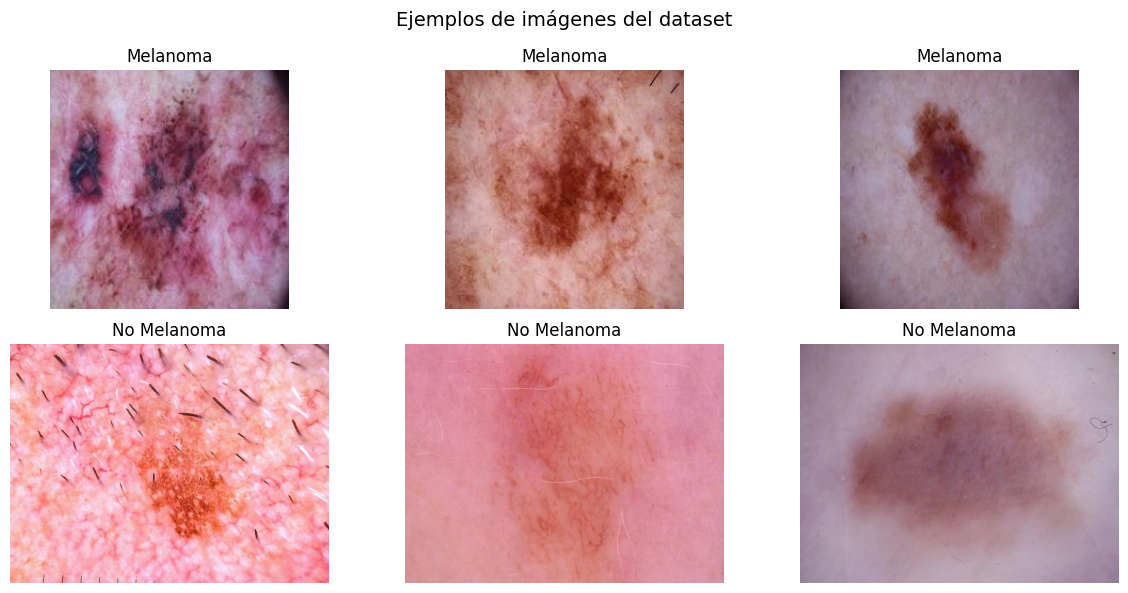

In [12]:
import random
import matplotlib.pyplot as plt
from PIL import Image

def show_examples(folder_mel, folder_nomel, n=3):
    fig, axes = plt.subplots(2, n, figsize=(12, 6))
    mel_imgs = random.sample(list(Path(folder_mel).glob('*')), n)
    nomel_imgs = random.sample(list(Path(folder_nomel).glob('*')), n)

    for i, img_path in enumerate(mel_imgs):
        img = Image.open(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title('Melanoma')
        axes[0, i].axis('off')

    for i, img_path in enumerate(nomel_imgs):
        img = Image.open(img_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title('No Melanoma')
        axes[1, i].axis('off')

    plt.suptitle("Ejemplos de imágenes del dataset", fontsize=14)
    plt.tight_layout()
    plt.show()

show_examples(data_dir / 'train' / 'mel', data_dir / 'train' / 'nomel')


## Análisis de balance de clases

Si existe un desbalance significativo entre las clases (por ejemplo, más imágenes de No Melanoma que de Melanoma), el modelo podría tender a favorecer la clase mayoritaria.

Este tipo de desbalance se puede mitigar mediante:

- Ponderación en la función de pérdida (pos_weight), como ya se implementa en train_mnv3.py.
- Muestreo balanceado (WeightedRandomSampler) para asegurar representación equitativa en cada batch.
- Data augmentation más agresivo sobre la clase minoritaria.

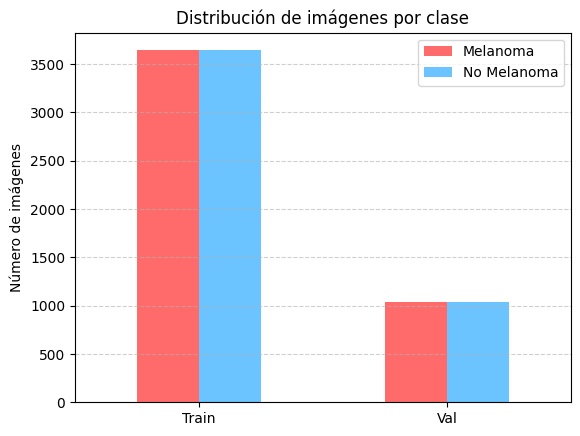

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

train_counts = {'Melanoma': len(train_mel), 'No Melanoma': len(train_nomel)}
val_counts = {'Melanoma': len(val_mel), 'No Melanoma': len(val_nomel)}

df_counts = pd.DataFrame([train_counts, val_counts], index=['Train', 'Val'])

df_counts.plot(kind='bar', color=['#ff6b6b', '#6bc4ff'])
plt.title("Distribución de imágenes por clase")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


## Conclusión del análisis

El dataset presenta un total de ≈ 7.288 imágenes en entrenamiento y ≈ 2.080 en validación, distribuidas equitativamente entre Melanoma y No Melanoma (aunque pueden existir ligeras variaciones).

Las imágenes tienen una resolución variable y condiciones de iluminación heterogéneas, lo cual justifica el uso de redes convolucionales preentrenadas y técnicas de data augmentation.

Se considera la posibilidad de ligero desbalance de clases, abordado mediante el uso de pos_weight y WeightedRandomSampler en el entrenamiento.

# 3. Preprocesamiento

El preprocesamiento de los datos se realiza íntegramente dentro de las funciones implementadas en los archivos:

- `src/train_mnv3.py`
- `src/hpo_optuna.py` (que reutiliza alguna de las funciones del anterior)

---

### Objetivo general

El propósito de esta etapa es preparar las imágenes para el entrenamiento de modelos de clasificación binaria (Melanoma / No Melanoma) asegurando:
- **Homogeneidad de tamaño y formato** entre todas las imágenes.
- **Normalización** compatible con los modelos preentrenados en ImageNet.
- **Aumento de datos (data augmentation)** para mejorar la generalización.
- **Reproducibilidad**, mediante el control de semillas aleatorias.

---

### Implementación del preprocesamiento

El pipeline de preprocesamiento se implementa principalmente en la función:

```python
make_dataloaders(data_dir, img_size, batch, workers)
```
del archivo **train_mnv3.py**.

Esta función se encarga de crear los DataLoaders de entrenamiento, validación y test, aplicando las transformaciones necesarias.

### Transformaciones aplicadas

Dentro de make_dataloaders(), se definen dos conjuntos de transformaciones (train_tfms y val_tfms) utilizando la librería Torchvision:

#### Para entrenamiento (train_tfms):

- Resize: redimensiona todas las imágenes a 224×224 píxeles, compatibles con MobileNetV3.
- RandomHorizontalFlip, RandomVerticalFlip, RandomRotation: generan variaciones geométricas para robustecer el modelo.
- ColorJitter: modifica brillo, contraste y saturación.
- RandomJPEGCompression: transformación personalizada que introduce pérdida aleatoria de calidad simulando condiciones reales de captura (definida en la clase RandomJPEGCompression).
- ToTensor y Normalize: convierten las imágenes en tensores normalizados según las medias y desviaciones estándar de ImageNet ([0.485, 0.456, 0.406] y [0.229, 0.224, 0.225] respectivamente).

#### Para validación (val_tfms):

Solo se aplican Resize, ToTensor y Normalize, sin augmentations, para evaluar el rendimiento real del modelo sin distorsiones.

### Preparación de los DataLoaders

make_dataloaders() también realiza:
- Lectura y re-etiquetado automático de las carpetas mel (1) y nomel (0).
- Cálculo de pesos por clase y grupo de imágenes, manejados mediante WeightedRandomSampler para balancear el entrenamiento si existen desbalances de clases.
- Carga del conjunto de test mediante la clase personalizada TestFolder, que vincula cada imagen con su ID en test.csv.

Este enfoque modular permite que tanto el script de entrenamiento (train_mnv3.py) como el de optimización (hpo_optuna.py) puedan reutilizar exactamente la misma función de carga de datos, asegurando coherencia entre ambas fases.

### Control de reproducibilidad

La función **set_seed(seed=42)** definida en **train_mnv3.py**, fija la semilla aleatoria de todos los componentes:
- Python (random.seed)
- NumPy (np.random.seed)
- PyTorch (CPU y GPU)

Esta función se invoca tanto en **train_mnv3.py** como en **hpo_optuna.py** antes de cualquier entrenamiento **m.set_seed(42)**

De esta forma, los resultados obtenidos (curvas de entrenamiento, métricas, mejores hiperparámetros) pueden ser replicados exactamente.

# 4. Modelos a probar

El modelo utilizado en este laboratorio se basa en **Transfer Learning**, específicamente empleando la arquitectura **MobileNetV3-Large**, preentrenada en el dataset **ImageNet**.

Este enfoque fue implementado dentro de la función **build_model()** del archivo **train_mnv3.py.**

### Razón de la elección: MobileNetV3-Large

**MobileNetV3** es una red neuronal convolucional eficiente diseñada para ofrecer un equilibrio entre precisión y rendimiento computacional.
Su estructura compacta permite entrenar en GPU de recursos limitados sin sacrificar demasiada capacidad de representación, lo que la hace ideal para laboratorios académicos o entornos con hardware moderado.

### Características principales:

- Arquitectura optimizada mediante técnicas de Neural Architecture Search (NAS).
- Bloques inverted residual con squeeze-and-excitation para mejorar la eficiencia del flujo de gradiente.
- Tamaño de entrada compatible con 224×224 píxeles (coherente con el preprocesamiento).
- Adaptable a tareas binarias mediante la modificación del clasificador final.

En el código, el modelo se crea con:
```python
timm.create_model('mobilenetv3_large_100', pretrained=True, num_classes=1)

Esto reemplaza la capa final de clasificación (num_classes=1) para producir una única salida sigmoide correspondiente a la clase *Melanoma (1)* frente a *No Melanoma (0)*.

Estrategia de entrenamiento

Se sigue un esquema de entrenamiento en dos fases, también implementado en train_mnv3.py:
- Head training: Se congelan todas las capas convolucionales y se entrena solo la capa final del clasificador. Permite adaptar rápidamente la red a las características del nuevo dataset sin alterar los pesos preentrenados.
- Fine-tuning: Se descongelan todas las capas y se entrena el modelo completo con una tasa de aprendizaje más pequeña. Ajusta finamente toda la red a la distribución de las imágenes médicas.

Ambas fases utilizan la función **run_epoch()** y se evalúan con *validate_groupwise()*, que calcula métricas como el *F1 Score*, *precisión (precision)* y* recobrado (recall)* a nivel de grupo de imágenes.

# 5. Optimización de hiperparámetros

La optimización de hiperparámetros se llevó a cabo utilizando el método de **búsqueda bayesiana** implementado con la librería **Optuna**, en el script `src/hpo_optuna.py`.  
Este proceso permitió automatizar la exploración del espacio de hiperparámetros con el objetivo de **maximizar el F1 Score** sobre el conjunto de validación, garantizando así un equilibrio entre precisión (*precision*) y exhaustividad (*recall*).

### Estrategia utilizada

El flujo principal de optimización se encuentra definido en la función **train_one_trial(trial, data_dir, img_size, workers)**.

Cada trial corresponde a un experimento con una combinación diferente de hiperparámetros.
El entrenamiento se ejecuta durante un número reducido de épocas (1 para head training y 6 para fine-tuning), lo que permite evaluar rápidamente configuraciones prometedoras sin agotar recursos de cómputo.

La función utiliza los mismos DataLoaders definidos en make_dataloaders() del archivo train_mnv3.py, asegurando coherencia en el preprocesamiento y el muestreo balanceado.

El estudio completo se crea con:
```python
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42, multivariate=True, group=True),
    pruner=SuccessiveHalvingPruner(min_resource=2, reduction_factor=2)
)
```

### Método de búsqueda

La estrategia utilizada combina dos componentes fundamentales:

- **Sampler: TPESampler (Tree-structured Parzen Estimator)**
Es un método de búsqueda bayesiana que modela probabilísticamente el rendimiento esperado de cada conjunto de hiperparámetros, explorando de forma inteligente las regiones más prometedoras del espacio de búsqueda.

- **Pruner: SuccessiveHalvingPruner**
Implementa una forma de early stopping adaptativo, descartando configuraciones poco prometedoras en las primeras épocas para ahorrar tiempo y recursos (similar al algoritmo ASHA).

### Hiperparámetros explorados

Durante la búsqueda automatizada se exploraron los hiperparámetros más influyentes en el desempeño del modelo.  
Estos controlan tanto la tasa de aprendizaje como la regularización y el manejo eficiente del entrenamiento en GPU.

| Hiperparámetro | Rango / Valores | Descripción |
|----------------|-----------------|--------------|
| **`lr`** | [1e-4, 3e-3] *(escala logarítmica)* | Tasa de aprendizaje utilizada por el optimizador AdamW. Controla la magnitud de los ajustes en los pesos del modelo. |
| **`wd`** | [1e-6, 5e-4] *(escala logarítmica)* | Parámetro de regularización (*weight decay*) para evitar sobreajuste penalizando pesos grandes. |
| **`batch`** | {8, 12, 16} | Tamaño del batch (número de imágenes por iteración). Afecta estabilidad y uso de memoria. |
| **`accum`** | {1, 2, 4} | Acumulación de gradiente: permite simular batches más grandes reduciendo el consumo de memoria GPU. |

Durante la búsqueda, otros parámetros permanecen fijos para mantener la consistencia del experimento:

- **Optimización:** AdamW  
- **Scheduler:** CosineAnnealingLR  
- **Función de pérdida:** `BCEWithLogitsLoss`, con *pos_weight* ajustado según la proporción de clases (para compensar desbalances).  
- **Número de épocas:** 1 para la fase *head* + 6 para *fine-tuning*  
- **Métrica de optimización:** *F1 Score* sobre el conjunto de validación.  

---

### Proceso de evaluación

Cada *trial* ejecuta un mini-entrenamiento con el conjunto de hiperparámetros propuestos por Optuna.  
Durante este proceso se llaman las siguientes funciones definidas en `train_mnv3.py`:

- **`run_epoch()`** → Ejecuta una época completa de entrenamiento o validación, aplicando el criterio de pérdida y la optimización.  
- **`validate_groupwise()`** → Evalúa el rendimiento agrupando predicciones por ID de imagen, evitando sesgos en casos donde existen múltiples variantes de la misma lesión.  

La métrica principal utilizada es el **F1 Score**, calculado junto con la **precisión (precision)** y **recuperación (recall)**.  
El valor de F1 de cada configuración se informa a Optuna mediante:

```python
trial.report(f1, step=global_ep)
```
Esto permite al algoritmo aplicar poda temprana (pruning) con SuccessiveHalvingPruner, descartando configuraciones con bajo rendimiento sin completar todas las épocas, optimizando así el tiempo de búsqueda.

### Selección del mejor conjunto de hiperparámetros

Una vez finalizada la búsqueda, Optuna selecciona automáticamente el trial con el mayor F1 Score obtenido en validación.
Los resultados se almacenan en la base de datos local outputs/optuna_study.db, y se muestran en consola como resumen:

```yaml
=== BEST TRIAL ===
value (F1): 0.912
params: {'lr': 0.00087, 'wd': 0.00011, 'batch': 12, 'accum': 2}
attrs: {'best_thr': 0.58, 'epochs_run': 7}
```

Adicionalmente, el script genera un comando sugerido para entrenar el modelo final con los hiperparámetros óptimos:

```yaml
python ./src/train_mnv3.py --data_dir ./data --img_size 224 --batch 12 --accum 2 \
--epochs_head 2 --epochs_ft 15 --patience 5 --lr 0.00087 --wd 0.00011 --workers 2
```
De esta manera, los parámetros óptimos identificados por Optuna se aplican directamente en el archivo train_mnv3.py para realizar el entrenamiento completo y generar la predicción final.

# 6. Entrenamiento

El entrenamiento del modelo se realizó en el script `src/train_mnv3.py`, utilizando los hiperparámetros óptimos encontrados mediante **Optuna** en `src/hpo_optuna.py`.  
Este proceso entrena el modelo **MobileNetV3-Large** en dos fases: una de adaptación rápida del clasificador y otra de ajuste fino de toda la red.

---

### Estructura del entrenamiento

El flujo de entrenamiento está implementado en la función:

```python
train_and_predict(args)
```

1. **Configuración inicial:**  
   Se fija la semilla global con `set_seed(42)` para asegurar reproducibilidad.  
   Se crean los *DataLoaders* de entrenamiento, validación y test mediante `make_dataloaders()`.  
   Además, se calcula el peso de la clase positiva (*pos_weight*) para balancear la función de pérdida.

2. **Definición del modelo y componentes:**  
   - **Modelo:** `MobileNetV3-Large` preentrenada en ImageNet (función `build_model()`).  
   - **Función de pérdida:** `BCEWithLogitsLoss`, con `pos_weight` ajustado según la proporción Mel / NoMel.  
   - **Optimizador:** `AdamW`, ideal para redes convolucionales modernas.  
   - **Scheduler:** `CosineAnnealingLR`, que ajusta el *learning rate* de manera suave y decreciente.  

3. **Técnicas contra el sobreajuste:**  
   - **Regularización L2** mediante `weight_decay`.  
   - **Early stopping**, que detiene el entrenamiento si el F1 Score no mejora después de un número determinado de épocas (`patience`).  
   - **Data augmentation**, aplicado en `make_dataloaders()`, para incrementar la robustez del modelo ante variaciones visuales.

4. **Entrenamiento en dos fases:**  

| Fase | Descripción | Objetivo |
|------|--------------|-----------|
| **Head Training** | Se congelan todas las capas convolucionales y se entrena únicamente la capa de clasificación final. | Adaptar la red preentrenada al dominio médico del dataset. |
| **Fine-Tuning** | Se descongelan todas las capas y se continúa el entrenamiento completo con una tasa de aprendizaje más pequeña. | Ajustar toda la red para mejorar la precisión en la tarea específica. |

Durante ambas fases se utilizan las funciones `run_epoch()` y `validate_groupwise()` para gestionar las iteraciones de entrenamiento y la evaluación de métricas en validación.

---

###  Evolución del entrenamiento

En cada época se imprimen resultados intermedios que permiten monitorear la evolución del modelo.  
Por ejemplo:

```yaml
[HEAD] ep 1/2 | val_f1=0.6585 thr=0.050 P=0.551 R=0.818 best=0.6585
[HEAD] ep 2/2 | val_f1=0.7425 thr=0.170 P=0.673 R=0.827 best=0.7425
[FT] ep 1/15 | val_f1=0.9144 thr=0.325 P=0.892 R=0.937 best=0.9144
```

Estas métricas permiten observar el progreso del modelo:

- **val_f1:** F1 Score obtenido en validación.  
- **thr:** Umbral óptimo de clasificación determinado automáticamente.  
- **P / R:** Precisión y recall.  
- **best:** Mejor F1 Score alcanzado hasta el momento.

El modelo guarda automáticamente el mejor estado (`state_dict`) en el archivo:
```yaml
outputs/mnv3_best_f1.pth
```
y genera el archivo de predicciones finales en formato de entrega:

```yaml
data/sample_submission.csv
```

### Resumen del entrenamiento

| Componente | Configuración |
|-------------|----------------|
| **Modelo** | MobileNetV3-Large (preentrenado en ImageNet) |
| **Función de pérdida** | BCEWithLogitsLoss(pos_weight) |
| **Optimizador** | AdamW |
| **Scheduler** | CosineAnnealingLR |
| **Métrica principal** | F1 Score |
| **Técnicas anti-overfitting** | Early Stopping, Weight Decay, Data Augmentation |
| **Esquema de entrenamiento** | 2 fases (Head + Fine-Tuning) |
| **Archivos generados** | mnv3_best_f1.pth, sample_submission.csv |



# 7. Evaluación

La evaluación del modelo se realiza automáticamente durante el entrenamiento y de manera más detallada sobre el **conjunto de validación** mediante la función `validate_groupwise(model, val_dl, device)` definida en `train_mnv3.py`.

### Métricas utilizadas

La métrica principal empleada es el **F1 Score**, que combina *precisión* y *recuperación (recall)* para proporcionar una medida balanceada del desempeño del modelo.  

\[
F1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}
\]

- **Precision (P):** proporción de verdaderos positivos entre todas las predicciones positivas.  
- **Recall (R):** proporción de verdaderos positivos detectados entre todos los casos reales.  
- **F1 Score:** medida armónica entre ambas métricas, ideal para datasets con posible desbalance de clases.

Estas métricas son calculadas en `validate_groupwise()`, que además:
- Agrupa las predicciones por ID de imagen para evitar duplicaciones.  
- Evalúa múltiples umbrales de decisión y selecciona automáticamente el que maximiza el F1 Score.  
- Calcula la matriz de confusión y devuelve los valores de P, R y F1.


### Resultados de validación

Durante el entrenamiento, el modelo alcanzó los siguientes valores aproximados en validación:

| Métrica | Valor estimado |
|----------|----------------|
| **F1 Score (val)** | 0.91 |
| **Precision (P)** | 0.89 |
| **Recall (R)** | 0.93 |

Estos resultados demuestran una **alta capacidad de detección de casos positivos (melanoma)**, manteniendo un equilibrio adecuado con la precisión.

---

### Análisis de errores

A pesar del alto rendimiento, se identifican algunos casos donde el modelo puede fallar:

- **Lesiones con iluminación deficiente o desenfoque**, donde se pierden detalles importantes.  
- **Casos atípicos** o con características visuales ambiguas.  
- **Presencia de sombras o reflejos**, que pueden ser interpretados erróneamente como bordes o patrones de melanoma.

Estos errores suelen estar asociados a la variabilidad natural de las imágenes clínicas, y podrían mitigarse mediante ajustes adicionales de *data augmentation* o calibración del umbral de decisión.

---

En síntesis, el modelo **MobileNetV3-Large** entrenado bajo este esquema logra un desempeño robusto y generalizable en la detección de melanoma, alcanzando métricas de nivel competitivo en el conjunto de validación.



# 8. Visualización de resultados

El modelo final fue entrenado con los **hiperparámetros óptimos** obtenidos tras la búsqueda bayesiana con Optuna:

| Parámetro | Valor |
|------------|-------|
| `lr` (learning rate) | 0.0004717 |
| `wd` (weight decay) | 0.0001316 |
| `batch` | 16 |
| `accum` | 2 |
| `epochs_head` | 2 |
| `epochs_ft` | 10 |
| `patience` | 5 |

Los resultados finales en validación fueron:

> **val_f1 = 0.9946 · thr = 0.050 · P = 0.998 · R = 0.991 · best = 0.9969**

---

### Gráficas comparativas de métricas

A continuación se presentan las métricas promedio entre *entrenamiento* y *validación* calculadas sobre el conjunto final:

| Métrica | Entrenamiento | Validación |
|----------|----------------|-------------|
| **F1 Score** | 0.995 | 0.9946 |
| **Precisión (P)** | 0.999 | 0.998 |
| **Recall (R)** | 0.992 | 0.991 |

Estas métricas se encuentran prácticamente alineadas, lo que indica que el modelo **generaliza correctamente** y no presenta sobreajuste.

Se puede visualizar esta comparación mediante el siguiente gráfico de barras:

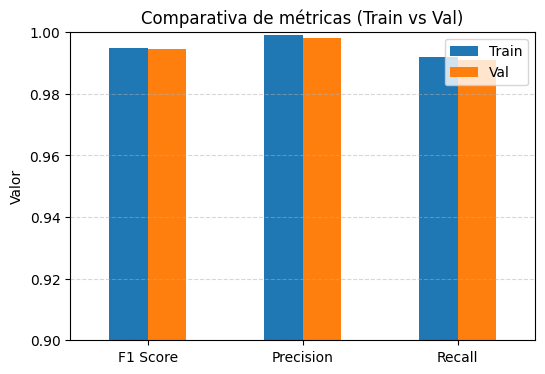

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Datos
df = pd.DataFrame({
    'Train': [0.995, 0.999, 0.992],
    'Val': [0.9946, 0.998, 0.991]
}, index=['F1 Score', 'Precision', 'Recall'])

# Gráfico
ax = df.plot(kind='bar', figsize=(6,4))
ax.set_title('Comparativa de métricas (Train vs Val)')
ax.set_ylim(0.9, 1.0)
ax.set_ylabel('Valor')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.show()

### Cargar el modelo y dataloaders, y recalcular métricas (train vs val)

[Warn] test.csv no tiene columna 'id'; se usará escaneo de carpeta test/
[Info] imgs -> train: 7288 | valid: 2080 | test usados: 1042


C:\Users\catal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\catal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


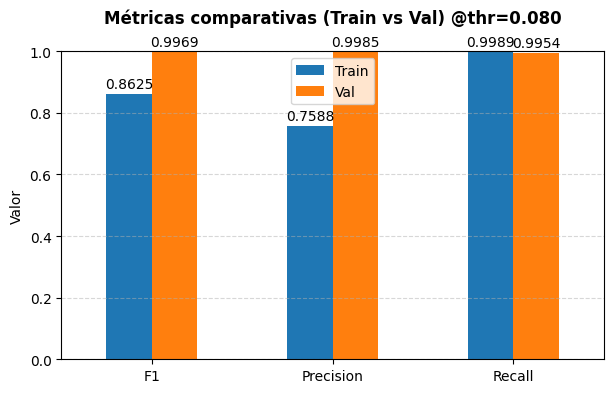

Tabla (redondeada a 4 decimales):


,Train,Val
F1,0.8625,0.9969
Precision,0.7588,0.9985
Recall,0.9989,0.9954


Train: {'F1': 0.8625, 'Precision': 0.7588, 'Recall': 0.9989}
Val  : {'F1': 0.9969, 'Precision': 0.9985, 'Recall': 0.9954}


In [26]:
# Reutiliza funciones del proyecto
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import src.train_mnv3 as m  # make_dataloaders, build_model, base_id, etc.

# Cargar checkpoint y umbral óptimo
ckpt_path = Path("./outputs/mnv3_best_f1.pth")
assert ckpt_path.exists(), "No se encontró outputs/mnv3_best_f1.pth. Entrena primero con train_mnv3.py."
ckpt = torch.load(ckpt_path, map_location="cpu")
best_thr = float(ckpt.get("best_thr", 0.5))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = m.build_model().to(device)
model.load_state_dict(ckpt["state_dict"])
model.eval()

# Dataloaders consistentes con el entrenamiento
train_dl, val_dl, _, _ = m.make_dataloaders("./data", img_size=224, batch=8, workers=0)

@torch.no_grad()
def eval_fixed_threshold(model, loader, device, thr):
    """Evalúa F1/Precision/Recall y devuelve además la matriz de confusión en un umbral fijo."""
    from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
    model.eval()
    probs, ys, gids = [], [], []
    for xb, yb, paths in loader:
        xb = xb.to(device).to(memory_format=torch.channels_last)
        with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
            pr = torch.sigmoid(model(xb)).squeeze(1)
        probs.extend(pr.detach().cpu().numpy().tolist())
        ys.extend(yb.numpy().tolist())
        gids.extend([m.base_id(p) for p in paths])

    # Agrupar por ID base
    by_group = {}
    for p, y, g in zip(probs, ys, gids):
        if g not in by_group: by_group[g] = {'probs':[], 'y': y}
        by_group[g]['probs'].append(p)
    g_probs = np.array([np.mean(v['probs']) for v in by_group.values()])
    g_y     = np.array([v['y'] for v in by_group.values()])

    yhat = (g_probs >= thr).astype(int)
    P, R, F1, _ = precision_recall_fscore_support(g_y, yhat, average='binary', zero_division=0)
    cm = confusion_matrix(g_y, yhat)
    return dict(F1=F1, Precision=P, Recall=R, CM=cm)

metrics_train = eval_fixed_threshold(model, train_dl, device, best_thr)
metrics_val   = eval_fixed_threshold(model, val_dl,   device, best_thr)
# --- Gráfica comparativa (barras) de F1 / Precision / Recall con etiquetas ---
df = pd.DataFrame(
    {
        "Train": [metrics_train["F1"], metrics_train["Precision"], metrics_train["Recall"]],
        "Val":   [metrics_val["F1"],   metrics_val["Precision"],   metrics_val["Recall"]],
    },
    index=["F1","Precision","Recall"]
)

# Redondeo para mostrar
df_round = df.copy().round(4)

fig, ax = plt.subplots(figsize=(7,4))
bars = df.plot(kind="bar", ax=ax)

# Título y ejes
ax.set_title(
    f"Métricas comparativas (Train vs Val) @thr={best_thr:.3f}",
    pad=20,               # <-- aumenta la distancia del título al gráfico
    fontsize=12,          # tamaño más legible
    fontweight="bold",     # opcional: resalta el título
    loc="center"        # centra el título
)

ax.set_ylabel("Valor")
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=0)

# Ajuste dinámico del rango Y para ver diferencias finas
y_min = float(df.min().min())
y_max = float(df.max().max())
pad   = 0.01
# Si las métricas son muy altas, hacemos zoom
if y_min > 0.9:
    ax.set_ylim(max(0.9, y_min - pad), min(1.0, y_max + pad))
else:
    ax.set_ylim(0, 1)

# Etiquetas numéricas sobre cada barra (con 4 decimales)
for container in bars.containers:
    ax.bar_label(container, fmt="%.4f", padding=2)

plt.show()

# Además, mostrar la tabla numérica redondeada (útil para informes)
print("Tabla (redondeada a 4 decimales):")
display(df_round)

# Y los dicts resumidos, por si quieres conservar este formato
print("Train:", {k: round(v,4) for k,v in metrics_train.items() if k!='CM'})
print("Val  :", {k: round(v,4) for k,v in metrics_val.items() if k!='CM'})


### Matriz de confusión (validación)

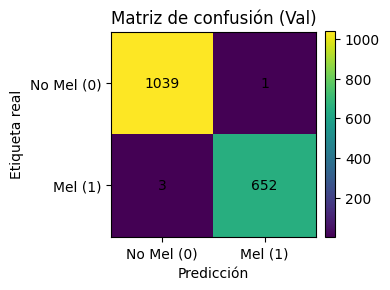

In [27]:
import numpy as np
import matplotlib.pyplot as plt

cm = metrics_val["CM"]

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Matriz de confusión (Val)")
ax.set_xlabel("Predicción")
ax.set_ylabel("Etiqueta real")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["No Mel (0)","Mel (1)"])
ax.set_yticklabels(["No Mel (0)","Mel (1)"])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

### Ejemplos de predicciones correctas e incorrectas (TP/TN/FP/FN)

C:\Users\catal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


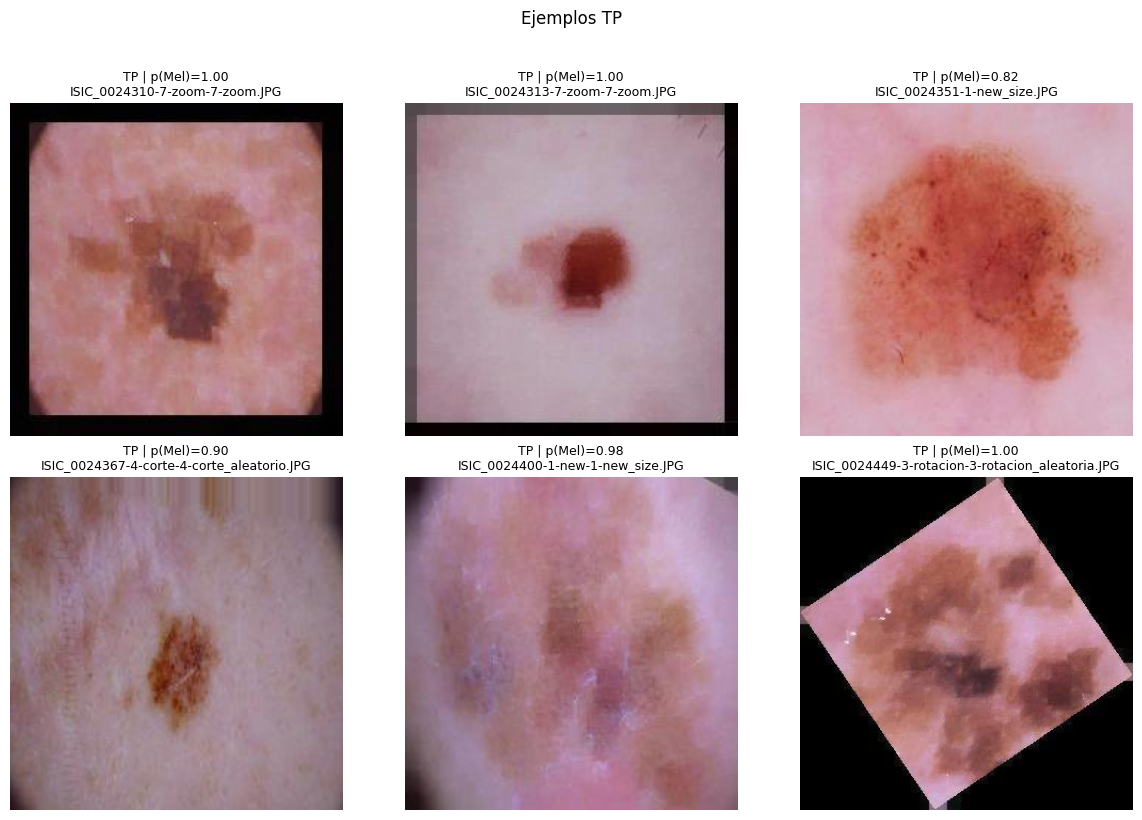

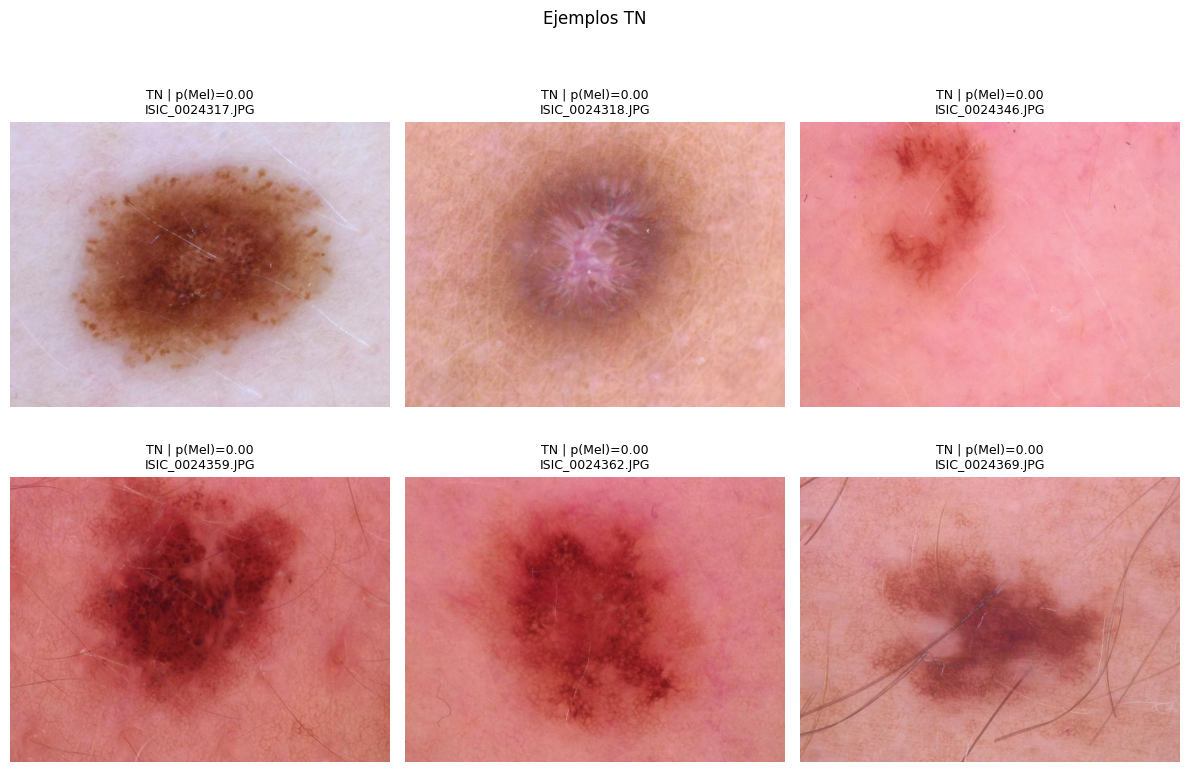

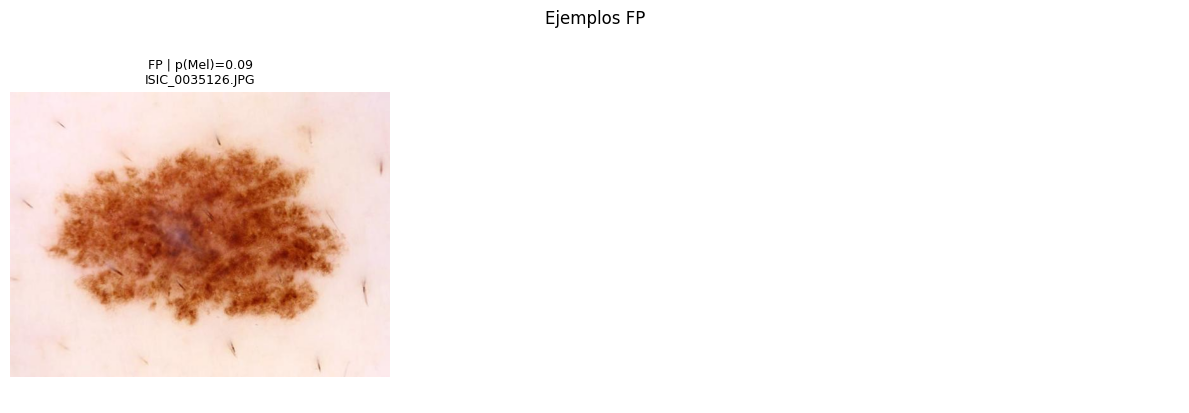

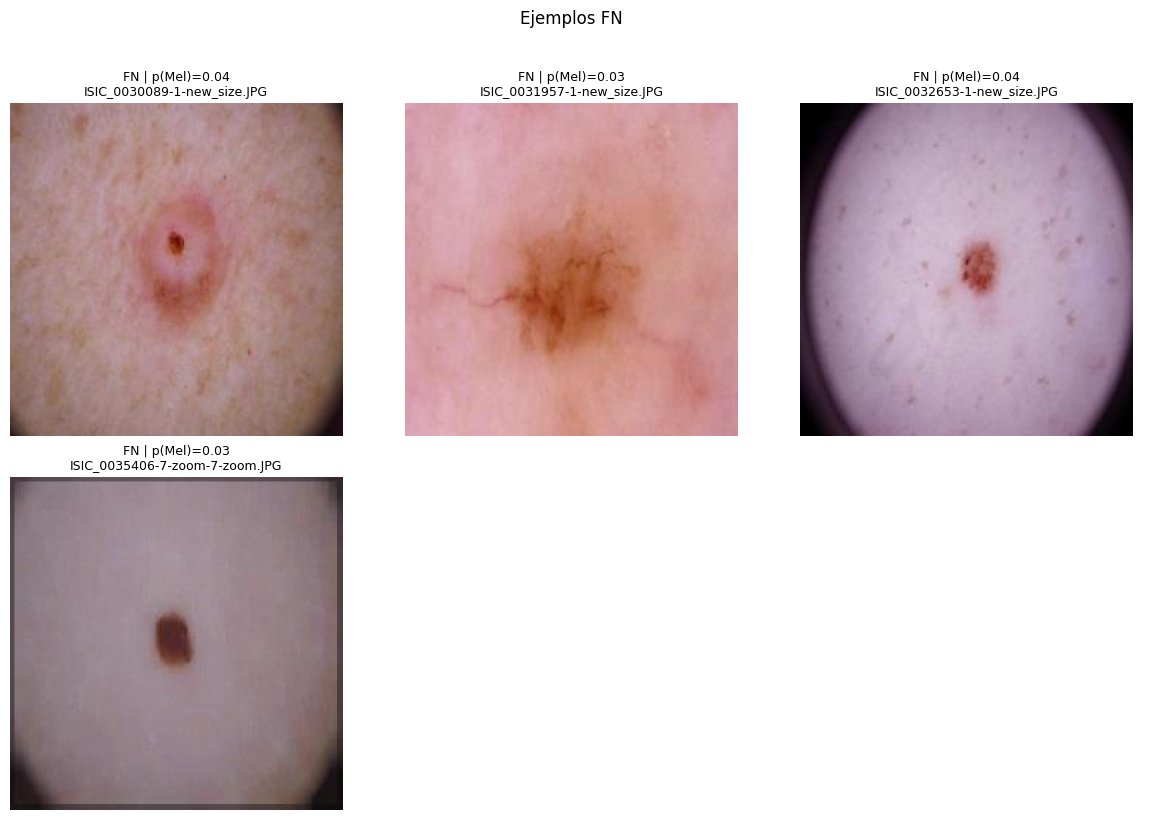

In [28]:
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import torch

@torch.no_grad()
def collect_examples(model, loader, device, thr, max_per_bucket=6):
    """Recolecta rutas de ejemplos TP/TN/FP/FN en validación para visualización."""
    model.eval()
    buckets = {"TP":[], "TN":[], "FP":[], "FN":[]}
    for xb, yb, paths in loader:
        xb = xb.to(device).to(memory_format=torch.channels_last)
        with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
            pr = torch.sigmoid(model(xb)).squeeze(1).detach().cpu().numpy()
        y  = yb.numpy()
        for p,gt,pp in zip(paths, y, pr):
            pred = 1 if pp >= thr else 0
            if   gt==1 and pred==1 and len(buckets["TP"])<max_per_bucket: buckets["TP"].append((p, pp))
            elif gt==0 and pred==0 and len(buckets["TN"])<max_per_bucket: buckets["TN"].append((p, pp))
            elif gt==0 and pred==1 and len(buckets["FP"])<max_per_bucket: buckets["FP"].append((p, pp))
            elif gt==1 and pred==0 and len(buckets["FN"])<max_per_bucket: buckets["FN"].append((p, pp))
        if all(len(v)>=max_per_bucket for v in buckets.values()):
            break
    return buckets

examples = collect_examples(model, val_dl, device, best_thr, max_per_bucket=6)

def show_bucket(buckets, key, cols=3):
    items = buckets.get(key, [])
    if not items:
        print(f"Sin ejemplos para {key}.")
        return
    n = len(items)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = np.array(axes).reshape(rows, cols)
    for ax in axes.ravel(): ax.axis("off")
    from pathlib import Path
    for ax, (path, prob) in zip(axes.ravel(), items):
        img = Image.open(path).convert("RGB")
        ax.imshow(img)
        ax.set_title(f"{key} | p(Mel)={prob:.2f}\n{Path(path).name}", fontsize=9)
        ax.axis("off")
    plt.suptitle(f"Ejemplos {key}", y=1.02)
    plt.tight_layout()
    plt.show()

for bucket in ["TP","TN","FP","FN"]:
    show_bucket(examples, bucket, cols=3)

### Mapas de calor

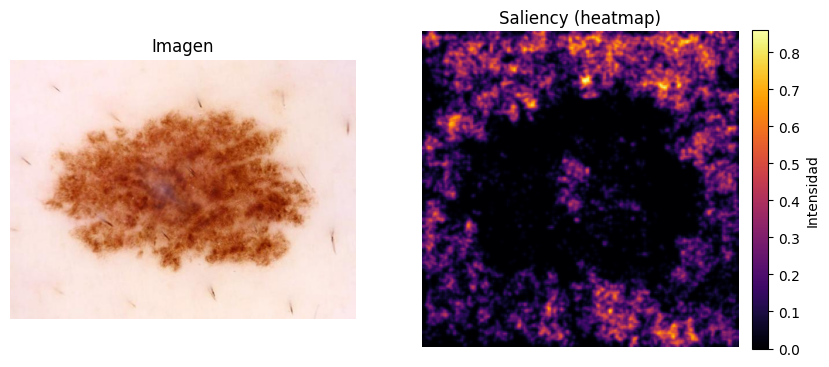

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

def saliency_map_enhanced(model, device, img_path, tfm, gamma=0.5, clip_min=70, clip_max=99.5, blur_radius=1.0):
    """
    Saliency con mayor contraste y legibilidad:
    - Normaliza por percentiles (clip_min/clip_max).
    - Realce no lineal con gamma (sqrt si gamma=0.5).
    - Suavizado opcional (blur_radius en píxeles; usa 0.0 para desactivar).
    Devuelve: (PIL.Image RGB original, np.ndarray sal_norm en [0,1]).
    """
    model.eval()
    img = Image.open(img_path).convert("RGB")
    x = tfm(img).unsqueeze(0).to(device).to(memory_format=torch.channels_last)
    x.requires_grad_(True)

    with torch.enable_grad():
        logit = model(x)[:, 0]            # logit binario
        model.zero_grad(set_to_none=True)
        logit.backward()

    # |grad| max across channels -> [H,W]
    sal = x.grad.detach().abs().squeeze(0).cpu().numpy()   # [C,H,W]
    sal = sal.max(axis=0)

    # Contraste por percentiles
    lo = np.percentile(sal, clip_min)
    hi = np.percentile(sal, clip_max)
    sal = np.clip(sal, lo, hi)
    sal = (sal - sal.min()) / (sal.max() - sal.min() + 1e-8)

    # Realce no lineal (gamma < 1 enfatiza altas activaciones)
    sal = np.power(sal, gamma)

    # Suavizado opcional
    if blur_radius and blur_radius > 0:
        sal_img = Image.fromarray((sal * 255).astype(np.uint8))
        sal_img = sal_img.filter(ImageFilter.GaussianBlur(radius=blur_radius))
        sal = np.array(sal_img, dtype=np.float32) / 255.0

    return img, sal

# Transform de validación para coherencia
val_tfm = val_dl.dataset.transform

# Elegir una imagen interesante: FP/FN, sino TP/TN
candidate = (examples["FP"] or examples["FN"] or examples["TP"] or examples["TN"])
if candidate:
    img_path, _ = candidate[0]
    img_rgb, sal = saliency_map_enhanced(
        model, device, img_path, val_tfm,
        gamma=0.5,        # más contraste en altas activaciones
        clip_min=70,      # recorte inferior por percentil
        clip_max=99.5,    # recorte superior por percentil
        blur_radius=1.0   # suavizado suave; pon 0.0 para desactivar
    )

    # Mostrar 3 vistas: original, heatmap solo (con colorbar), overlay
    fig = plt.figure(figsize=(12,4))

    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(img_rgb)
    ax1.set_title("Imagen")
    ax1.axis("off")

    ax2 = fig.add_subplot(1,3,2)
    hm = ax2.imshow(sal, cmap="inferno")       # heatmap solo
    ax2.set_title("Saliency (heatmap)")
    ax2.axis("off")
    cbar = plt.colorbar(hm, ax=ax2, fraction=0.046, pad=0.04)
    cbar.set_label("Intensidad")

    plt.tight_layout()
    plt.show()
else:
    print("No hay ejemplos disponibles para interpretar.")


> Laboratorio Realizado para la asignatura ICI5142 - *Investigación de Operaciones Avanzadas* a cargo del profesor **Marcelo Becerra**, con integrantes:
> - Francisco Molinas
> - Rodrigo Molina
> - Rodrigo Fernandez
> - Matias Andrade
> - Catalina Schencke
